In [46]:
using ReactionMechanismSimulator
using ReactionMechanismSimulator.Sundials
using ReactionMechanismSimulator.PythonPlot

# Read mechanism

In [36]:
phaseDict = readinput("/Users/hwpang/Software/ReactionMechanismSimulator.jl/src/testing/minimal.rms") 
spcs = phaseDict["phase"]["Species"];
rxns = phaseDict["phase"]["Reactions"];

[17:44:28] WARNING: not removing hydrogen atom without neighbors


# Create phase and domain

In [40]:
ig = IdealGas(spcs,rxns,name="phase");
domain,y0,p = ConstantTPDomain(phase=ig,initialconds=initialconds);

# Simulation conditions

In [41]:
tf = 1e-6
initialconds = Dict(["T"=>1350.0,"P"=>1.0e5,"ethane"=>1.0]);

# Simulate with QSSAs and isomer lumping

In [43]:
qssnames = ["[CH2][CH]C=C"]
isomergroups = [Dict("[CH2]CC=C"=>0.5,"[CH]=CCC"=>0.5)]

reducedmodelmappings = generateqsscmapping(ig,qssnames,isomergroups)

react = Reactor(domain,y0,(0.0,tf),reducedmodelmappings,[];p=p);
sol = solve(react.ode,react.recommendedsolver,abstol=1e-18,reltol=1e-6);
unlumpedbsol = Simulation(sol,domain,reducedmodelmappings,[],p);

  0.013309 seconds (55.31 k allocations: 2.223 MiB, 30.60% compilation time)
  2.229331 seconds (5.75 M allocations: 312.037 MiB, 6.51% gc time, 99.93% compilation time)


# Simulation the original model

In [44]:
react = Reactor(domain,y0,(0.0,tf);p=p);
sol = solve(react.ode,react.recommendedsolver,abstol=1e-18,reltol=1e-6);
bsol = Simulation(sol,domain,[],p);

  0.000688 seconds (4.49 k allocations: 307.578 KiB)


# Compare results

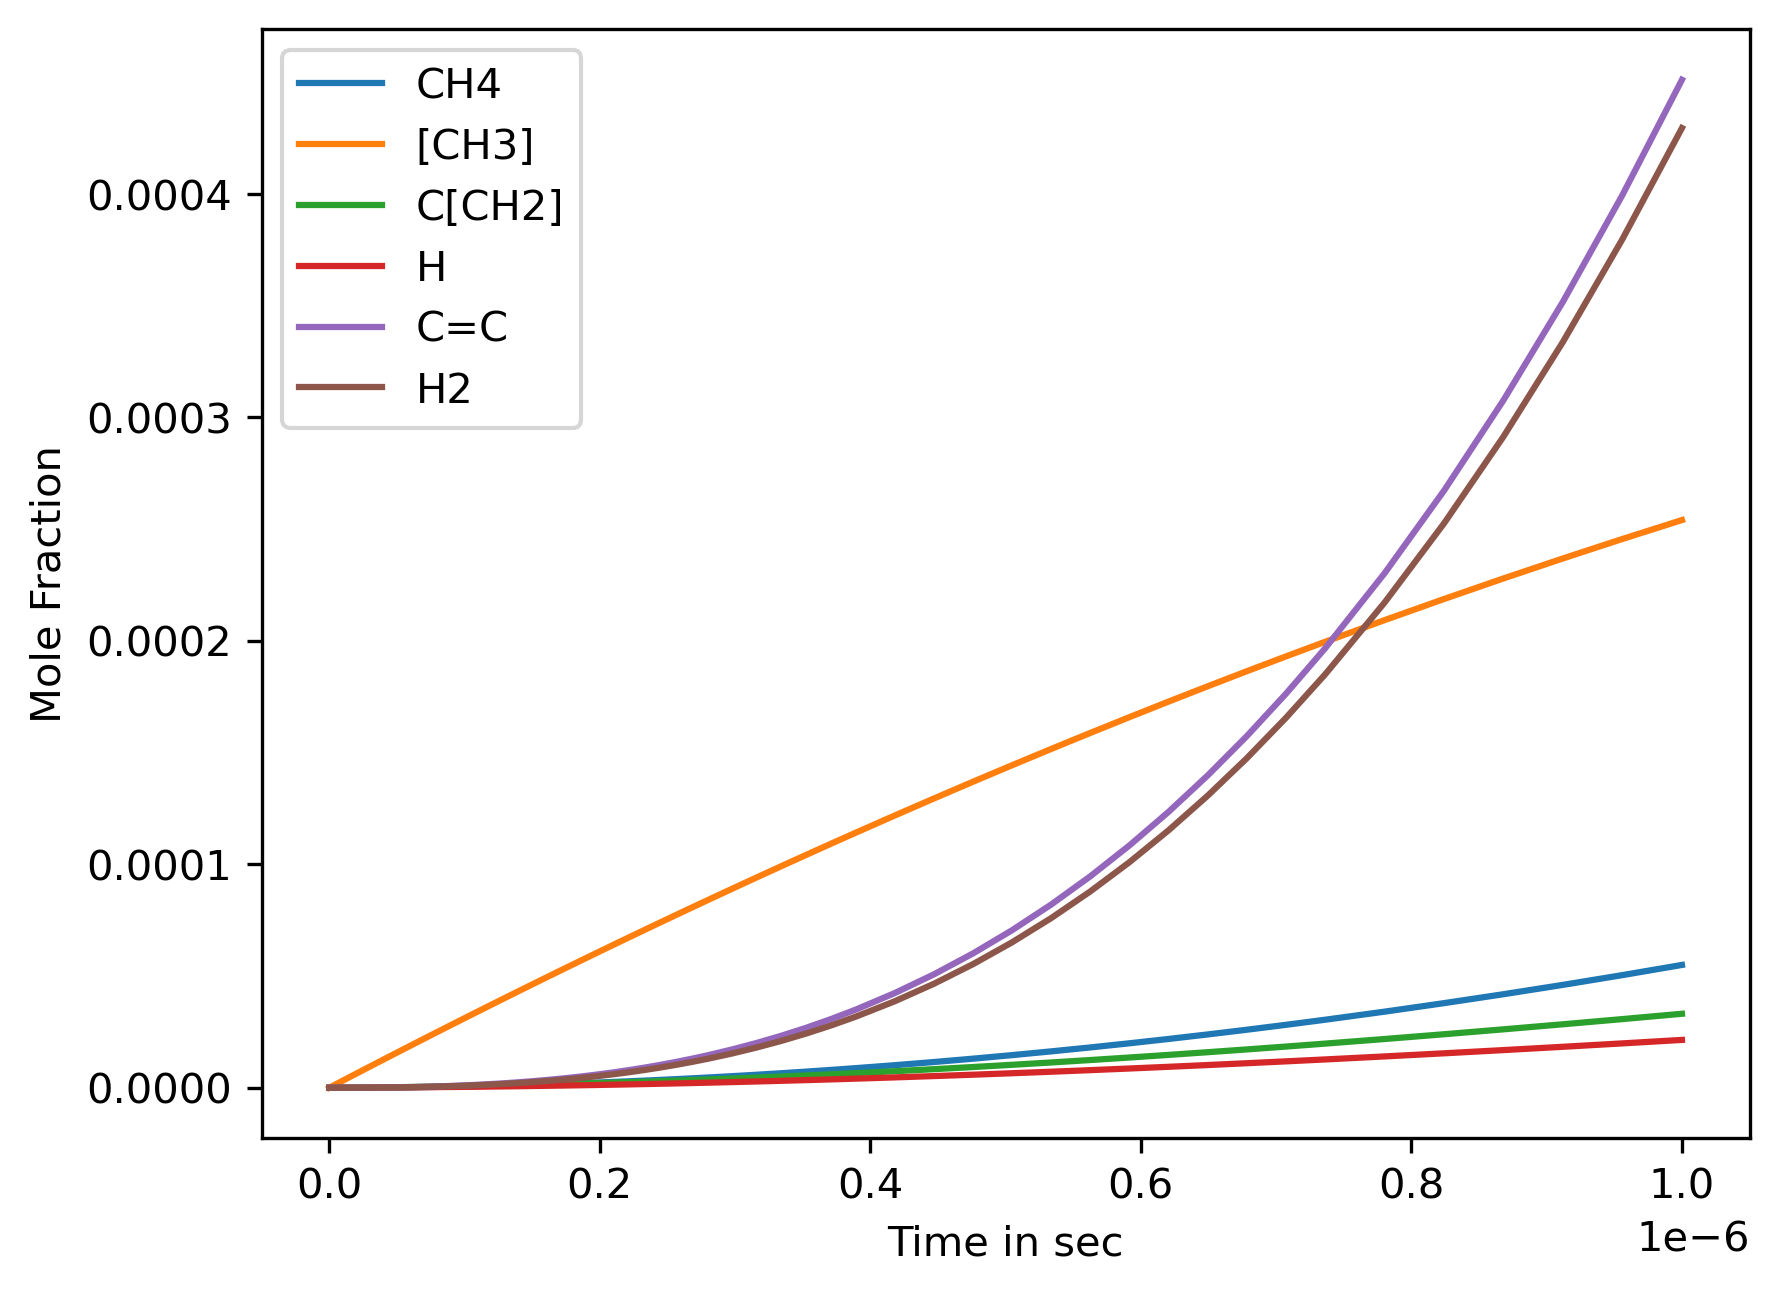

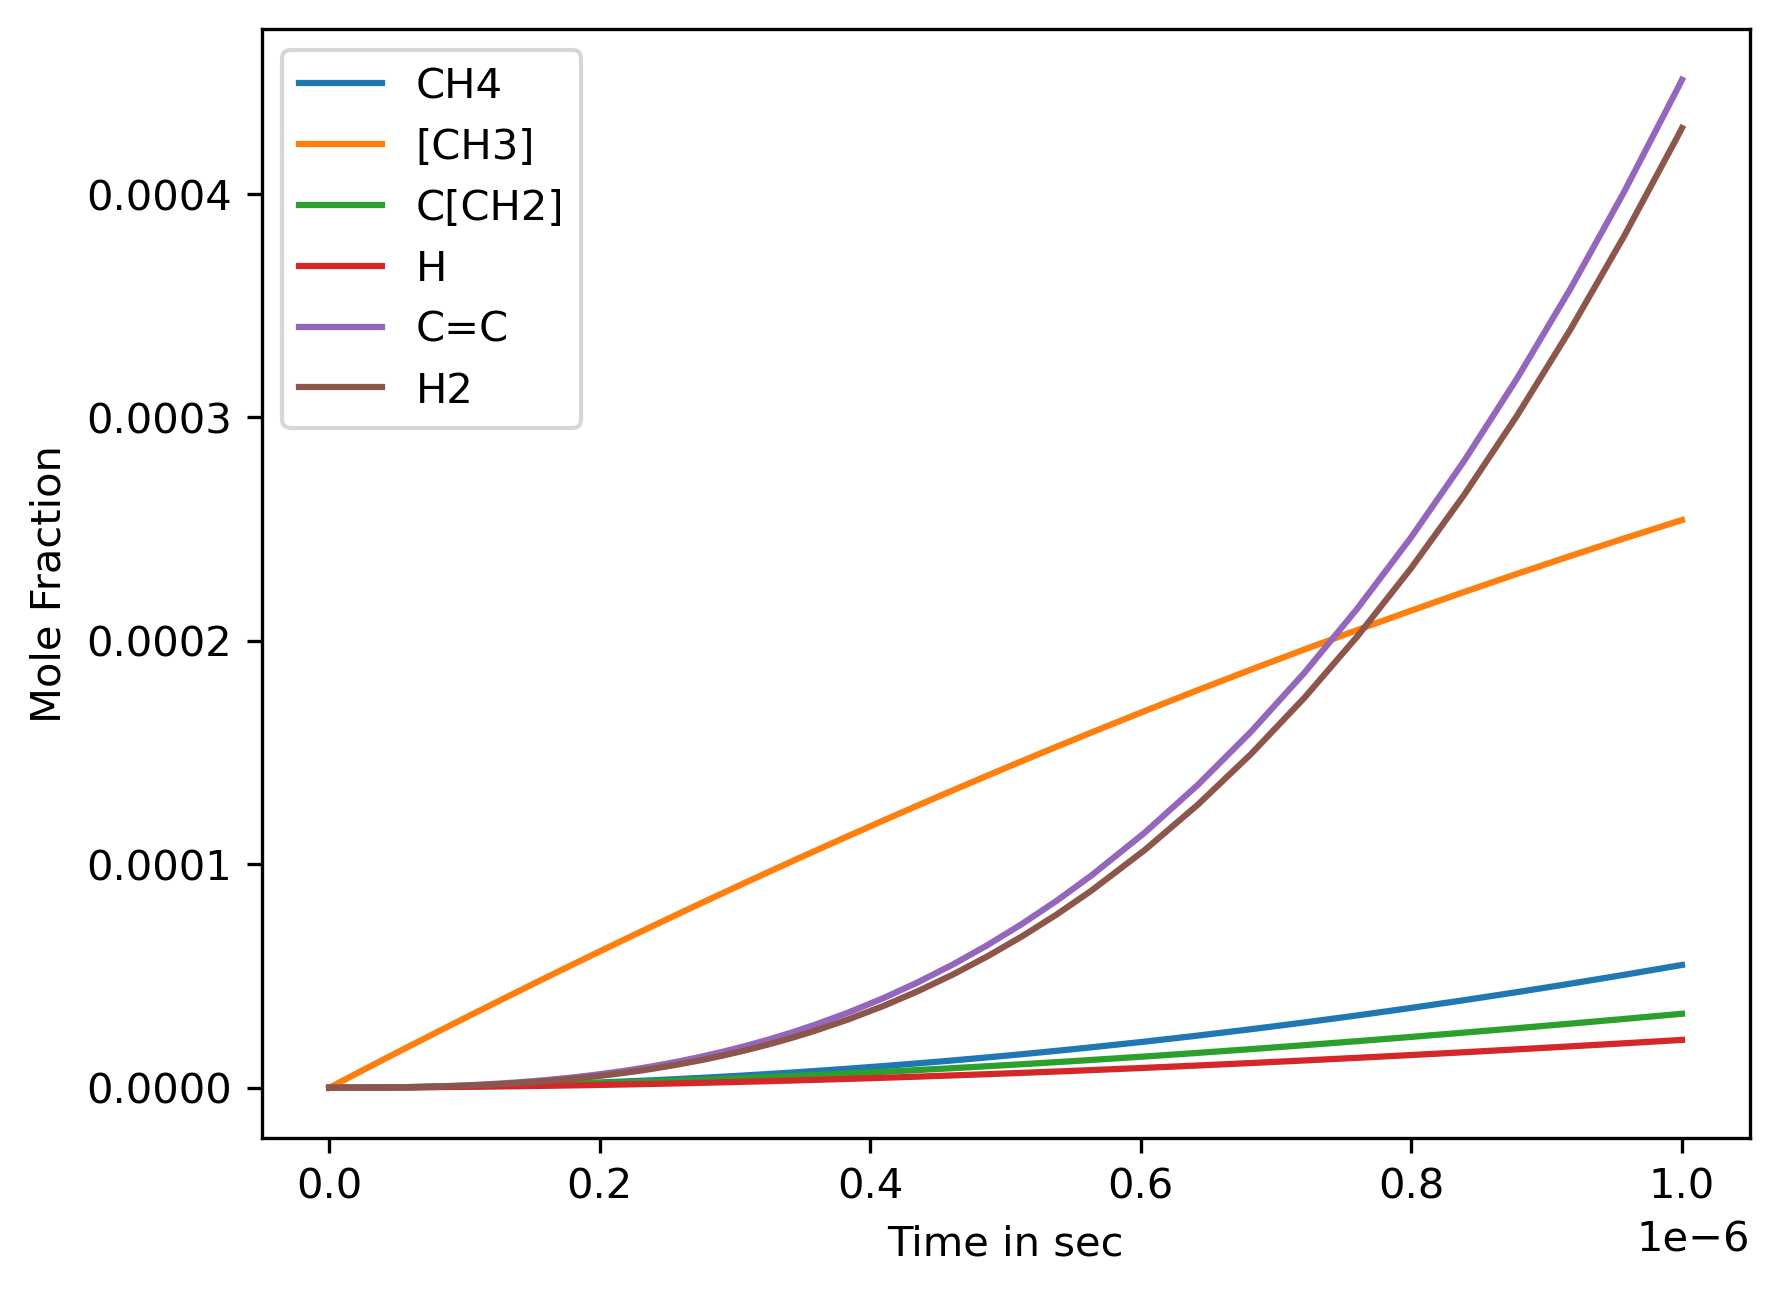

PyObject Text(69.99999999999999, 0.5, 'Mole Fraction')

In [63]:
# compare major products

figure(dpi=300)
plotmolefractions(unlumpedbsol,tol=1e-6, exclude=["ethane"])

figure(dpi=300)
plotmolefractions(bsol,tol=1e-6, exclude=["ethane"])

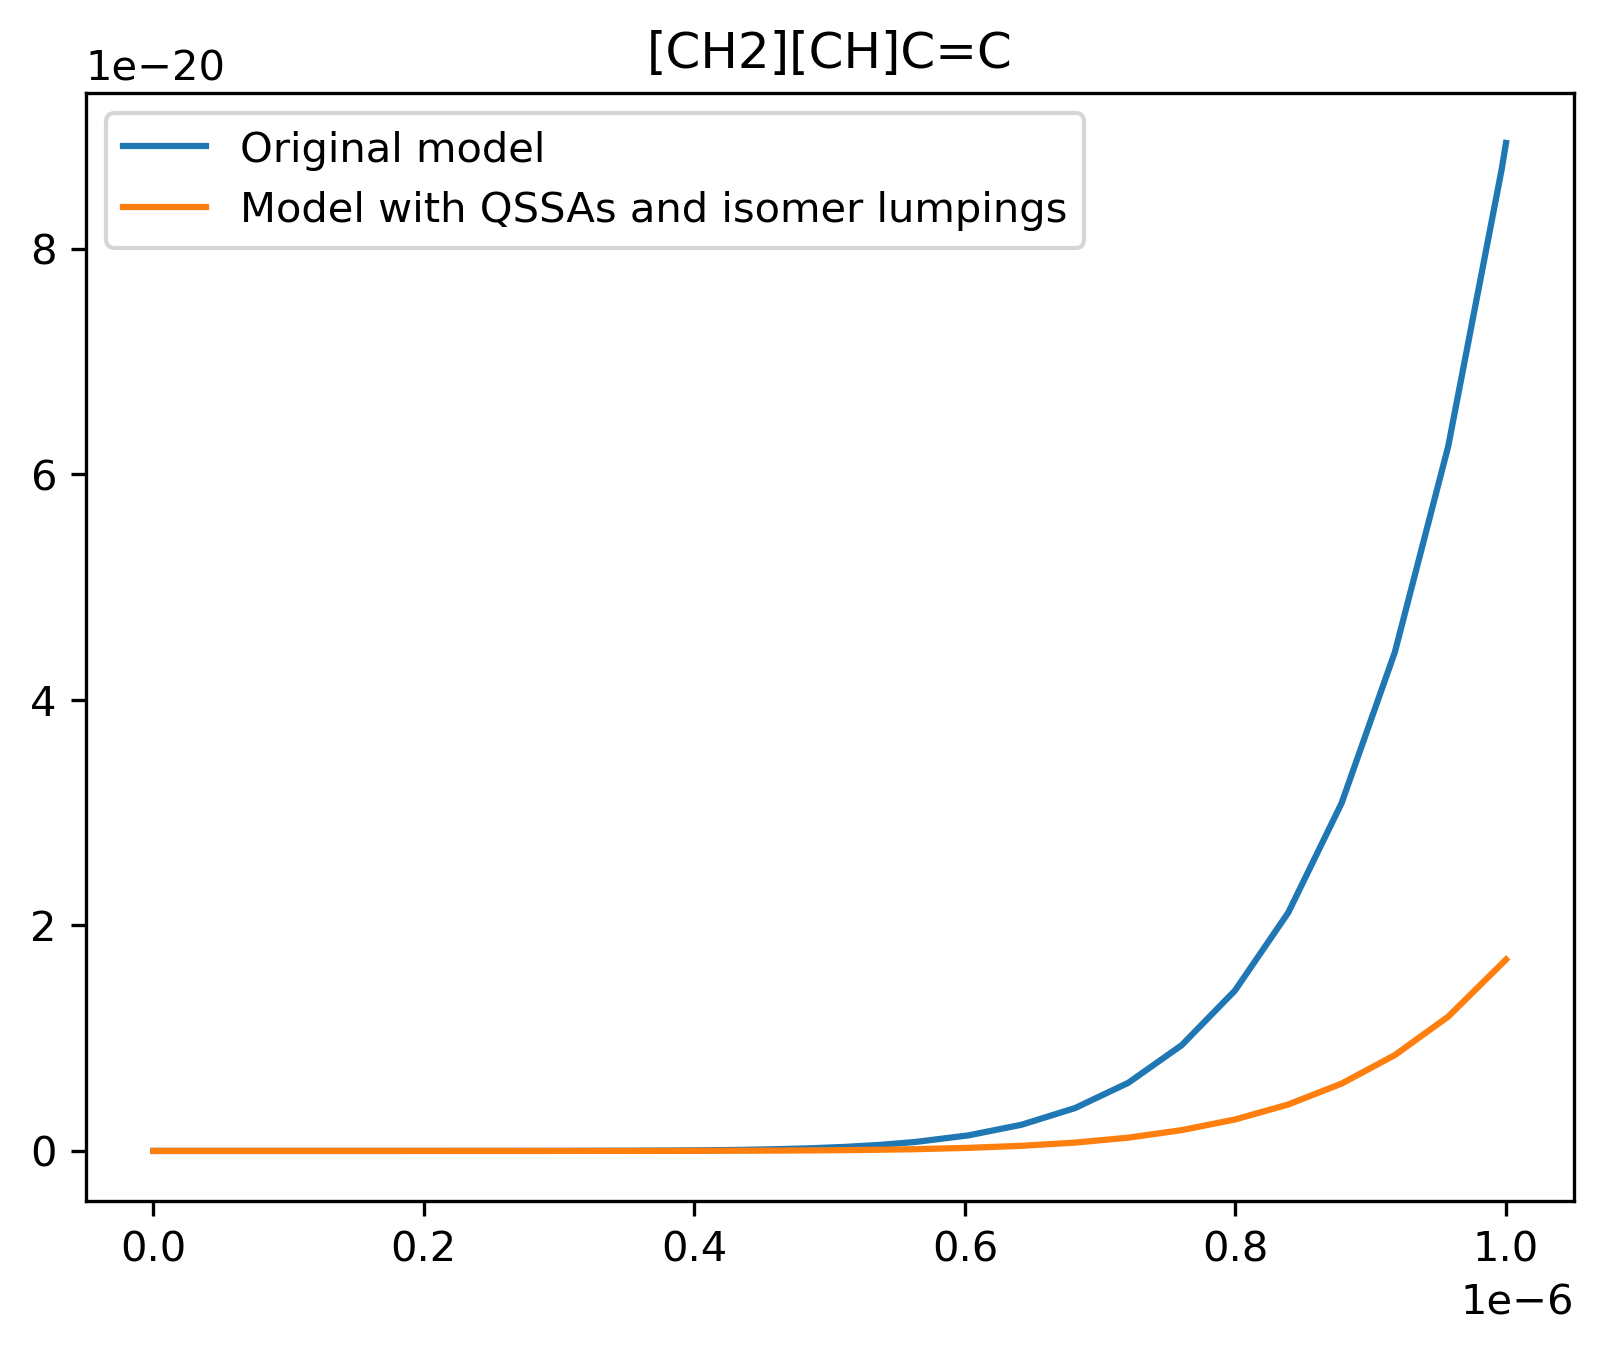

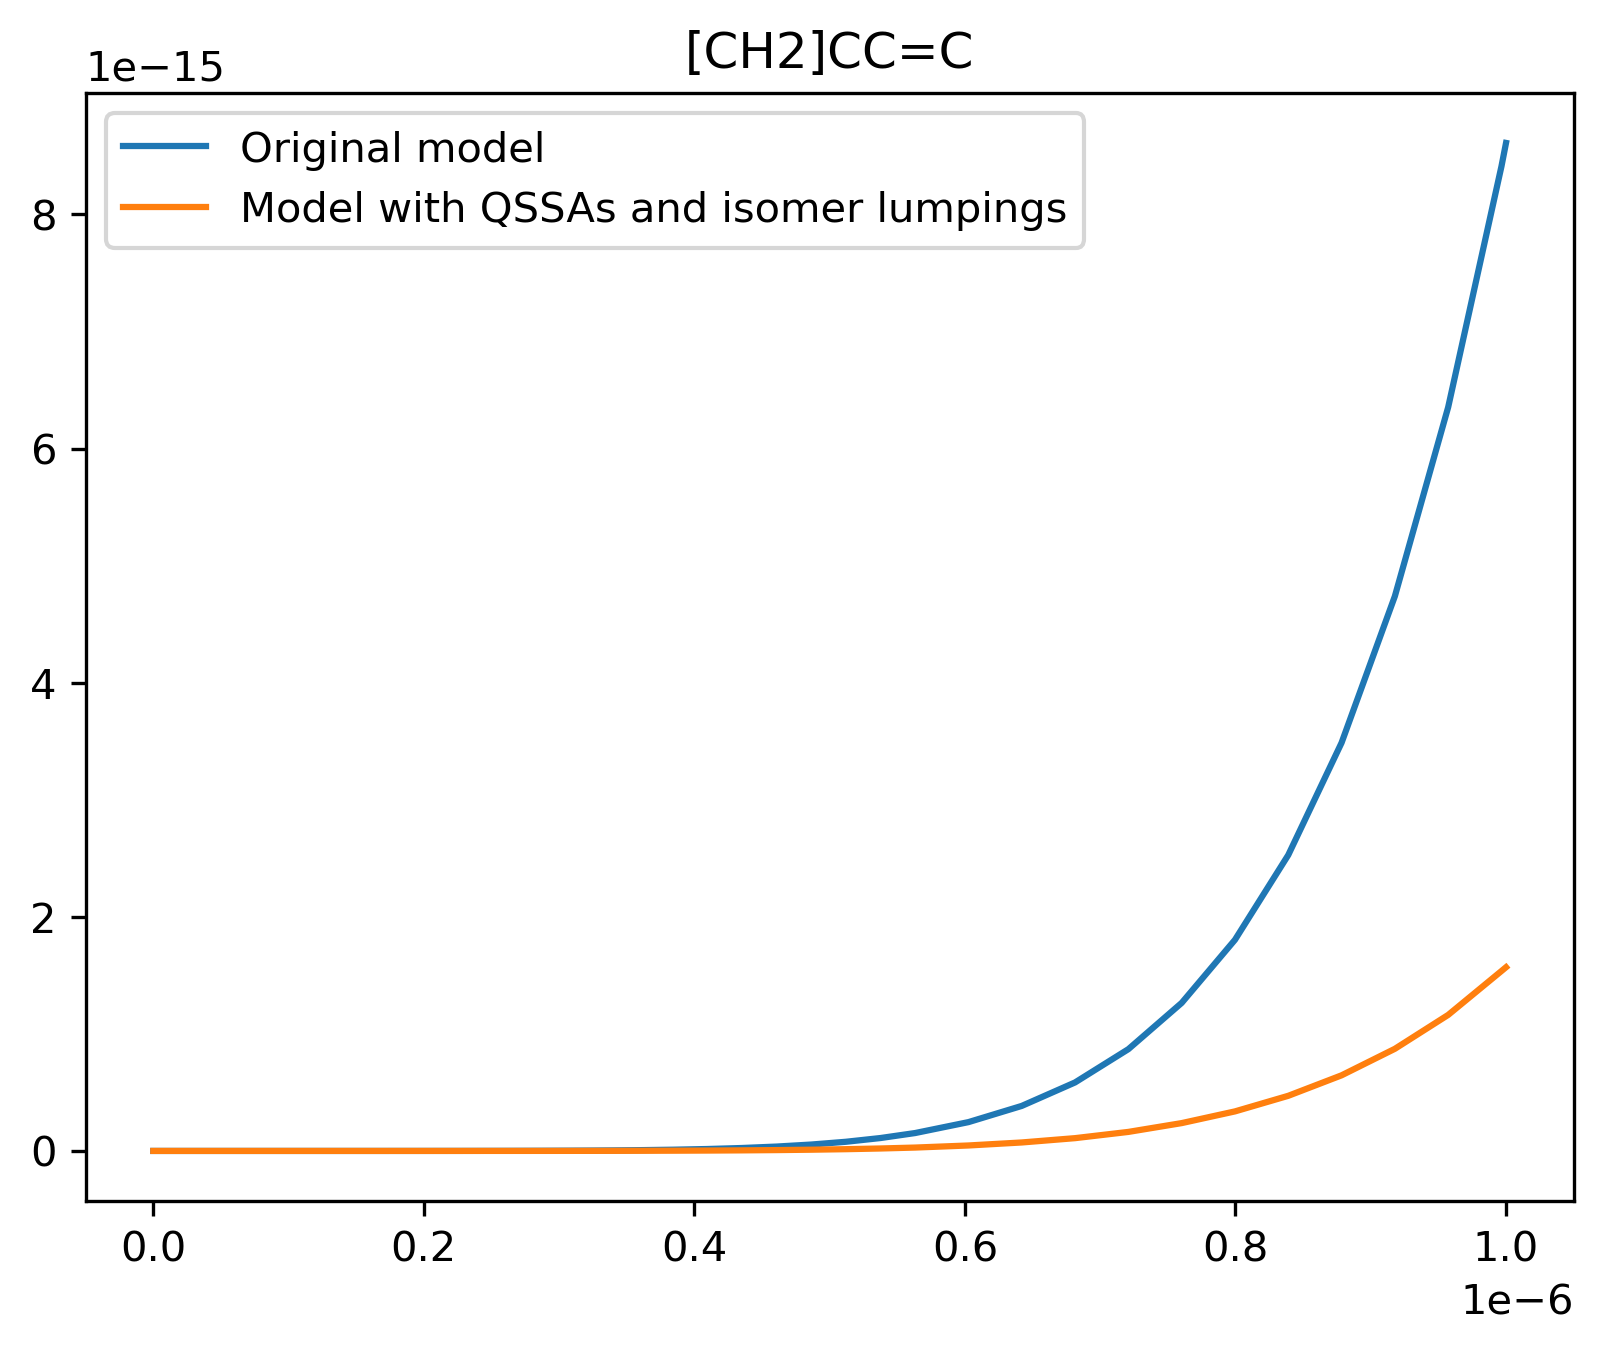

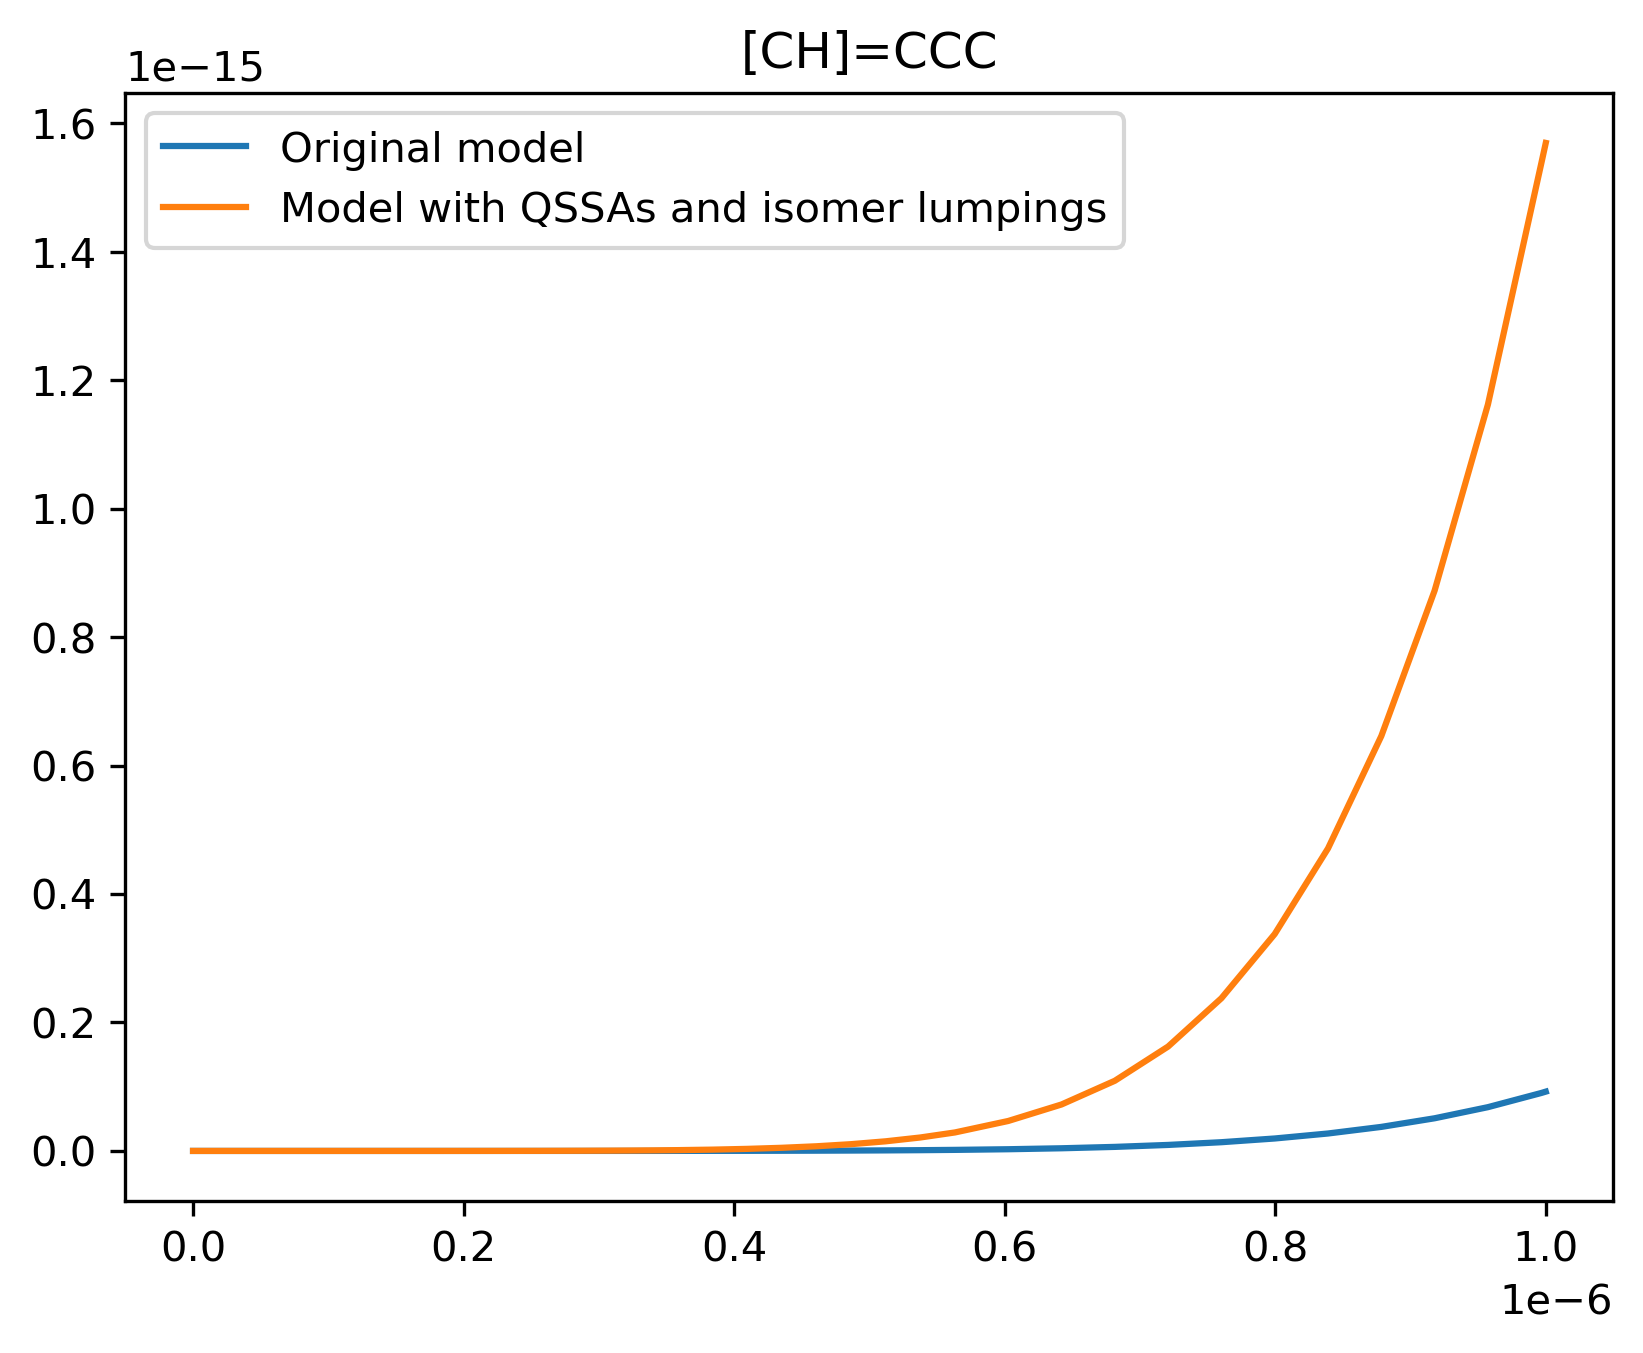

In [64]:
# compare the QSSA'd species and lumped isomers

spcnames = ["[CH2][CH]C=C", "[CH2]CC=C", "[CH]=CCC"]
for name in spcnames
    figure(dpi=300)
    title(name)
    plot(bsol.sol.t,[molefractions(bsol,name,t) for t in bsol.sol.t], label="Original model")
    plot(bsol.sol.t,[molefractions(unlumpedbsol,name,t) for t in bsol.sol.t], label="Model with QSSAs and isomer lumpings")
    legend()
end